In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
from strategy import *

%matplotlib inline

bt version :  (0, 2, 10)


In [2]:
# 투자자산
tickers = ['TQQQ','TMF']
safe_ticker = ['BIL']
# 월초 리밸런싱
run_on_end_of_period = False
# 지연시간 1일, 하루전 종가 기준으로 리밸런싱
lag = 1

In [3]:
data = yf.download(tickers+safe_ticker, end='2022-12-10')['Adj Close']
data = data[tickers+safe_ticker]
for c in data.columns:
    print(c, data[c].first_valid_index())
assets = data.dropna().copy()
    
start_day = assets.index.min()# + pd.DateOffset(months=12)
print('asset \n', assets)
print('start day : ', start_day)

[*********************100%***********************]  3 of 3 completed
TQQQ 2010-02-11 00:00:00
TMF 2009-04-16 00:00:00
BIL 2007-05-30 00:00:00
asset 
                  TQQQ        TMF        BIL
Date                                       
2010-02-11   0.431471   6.695426  86.559998
2010-02-12   0.433238   6.771189  86.559998
2010-02-16   0.450019   6.831800  86.559998
2010-02-17   0.457656   6.613166  86.503403
2010-02-18   0.466332   6.500601  86.541145
...               ...        ...        ...
2022-12-05  22.230000   9.230000  91.449997
2022-12-06  20.820000   9.590000  91.480003
2022-12-07  20.570000  10.230000  91.480003
2022-12-08  21.299999  10.160000  91.540001
2022-12-09  20.889999   9.380000  91.529999

[3231 rows x 3 columns]
start day :  2010-02-11 00:00:00


In [4]:
usdkrw = yf.download('KRW=X', end='2022-12-10')['Adj Close']
print('usdkrw \n', usdkrw)

assets_krw = pd.merge(data, usdkrw, on='Date', how='outer').sort_values('Date')
print('data_krw \n', assets_krw)

assets_krw = assets_krw[start_day:].fillna(method='ffill')
assets_krw.rename(columns={'Adj Close':'krw/usd'}, inplace=True)

for i in range(0, len(assets_krw.columns) - 1):
    assets_krw[assets_krw.columns[i]] = assets_krw[assets_krw.columns[i]] * assets_krw['krw/usd']
print('assets_krw \n', assets_krw)

[*********************100%***********************]  1 of 1 completed
usdkrw 
 Date
2003-12-01    1198.400024
2003-12-02    1195.000000
2003-12-03    1192.500000
2003-12-04    1190.099976
2003-12-05    1184.699951
                 ...     
2022-12-05    1299.170044
2022-12-06    1304.369995
2022-12-07    1319.709961
2022-12-08    1314.099976
2022-12-09    1316.630005
Name: Adj Close, Length: 4934, dtype: float64
data_krw 
                  TQQQ    TMF        BIL    Adj Close
Date                                                
2003-12-01        NaN    NaN        NaN  1198.400024
2003-12-02        NaN    NaN        NaN  1195.000000
2003-12-03        NaN    NaN        NaN  1192.500000
2003-12-04        NaN    NaN        NaN  1190.099976
2003-12-05        NaN    NaN        NaN  1184.699951
...               ...    ...        ...          ...
2022-12-05  22.230000   9.23  91.449997  1299.170044
2022-12-06  20.820000   9.59  91.480003  1304.369995
2022-12-07  20.570000  10.23  91.480003  131

In [5]:
# 매수&보유 백테스트
def long_only_ew(assets, start_day, name='long_only_ew'):
    s = bt.Strategy(name, [bt.algos.RunAfterDate(start_day),
                           bt.algos.RunOnce(),
                           bt.algos.SelectAll(),
                           bt.algos.WeighEqually(),
                           bt.algos.Rebalance()])
    return bt.Backtest(s, assets, initial_capital=10000.0)

In [6]:
# 벤치마크 수익율
bm = long_only_ew(assets[tickers[0]].to_frame(), start_day, 'benchmark({})'.format(tickers[0]))
bm2 = long_only_ew(assets[tickers[1]].to_frame(), start_day, 'benchmark({})'.format(tickers[1]))

bm_report = bt.run(bm)
bm2_report = bt.run(bm2)

Stat                 benchmark(TQQQ)
-------------------  -----------------
Start                2010-02-11
End                  2022-12-09
Risk-free rate       0.00%

Total Return         4721.83%
Daily Sharpe         0.80
Daily Sortino        1.26
CAGR                 35.29%
Max Drawdown         -80.64%
Calmar Ratio         0.44

MTD                  -11.33%
3m                   -29.99%
6m                   -30.34%
YTD                  -74.88%
1Y                   -74.28%
3Y (ann.)            3.04%
5Y (ann.)            12.63%
10Y (ann.)           34.73%
Since Incep. (ann.)  35.29%

Daily Sharpe         0.80
Daily Sortino        1.26
Daily Mean (ann.)    49.40%
Daily Vol (ann.)     61.42%
Daily Skew           -0.39
Daily Kurt           6.25
Best Day             26.99%
Worst Day            -34.47%

Monthly Sharpe       0.82
Monthly Sortino      1.58
Monthly Mean (ann.)  44.81%
Monthly Vol (ann.)   54.41%
Monthly Skew         -0.09
Monthly Kurt         0.18
Best Month           46.45%
W

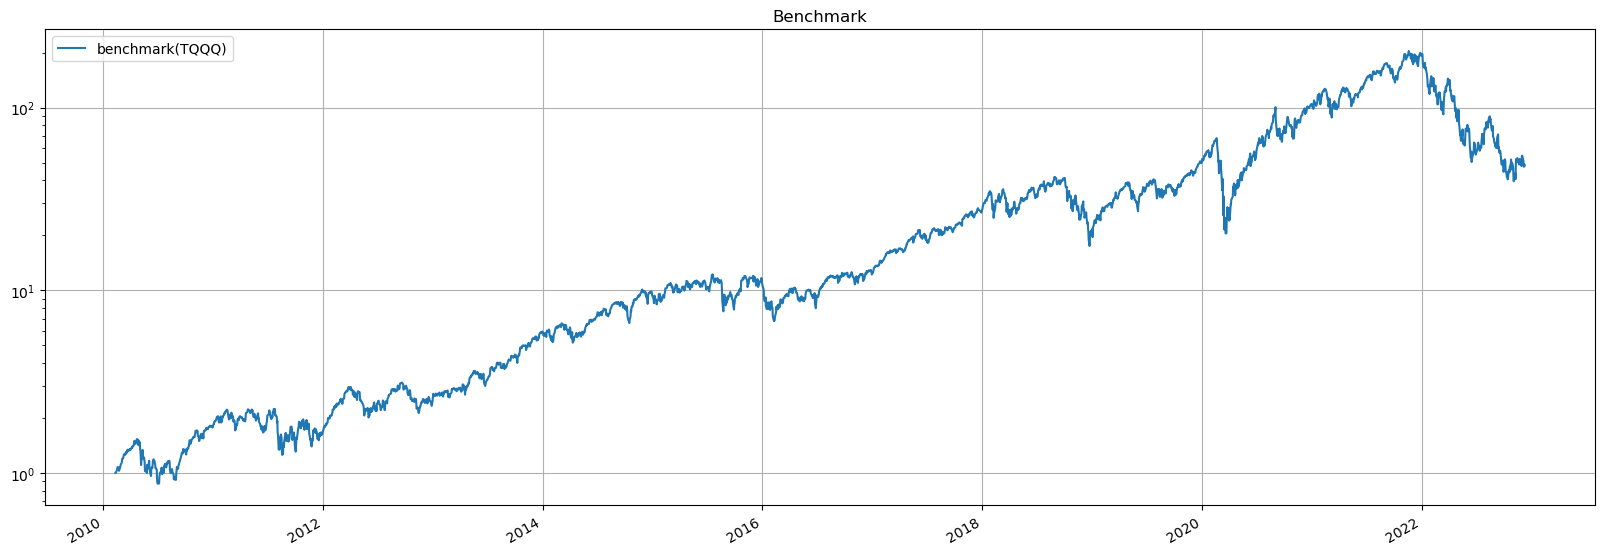

In [7]:
bm_report.prices[start_day:].rebase(1).plot(figsize=(20,7), grid=True, logy=True, title="Benchmark")
bm_report.prices[start_day:].calc_stats().display()

Stat                 benchmark(TMF)
-------------------  ----------------
Start                2010-02-11
End                  2022-12-09
Risk-free rate       0.00%

Total Return         38.51%
Daily Sharpe         0.28
Daily Sortino        0.47
CAGR                 2.57%
Max Drawdown         -87.19%
Calmar Ratio         0.03

MTD                  11.00%
3m                   -8.87%
6m                   -24.87%
YTD                  -66.43%
1Y                   -67.28%
3Y (ann.)            -29.15%
5Y (ann.)            -14.28%
10Y (ann.)           -6.34%
Since Incep. (ann.)  2.57%

Daily Sharpe         0.28
Daily Sortino        0.47
Daily Mean (ann.)    12.58%
Daily Vol (ann.)     44.77%
Daily Skew           0.01
Daily Kurt           3.74
Best Day             20.36%
Worst Day            -18.14%

Monthly Sharpe       0.25
Monthly Sortino      0.51
Monthly Mean (ann.)  10.15%
Monthly Vol (ann.)   40.83%
Monthly Skew         0.59
Monthly Kurt         0.72
Best Month           41.34%
Worst Mo

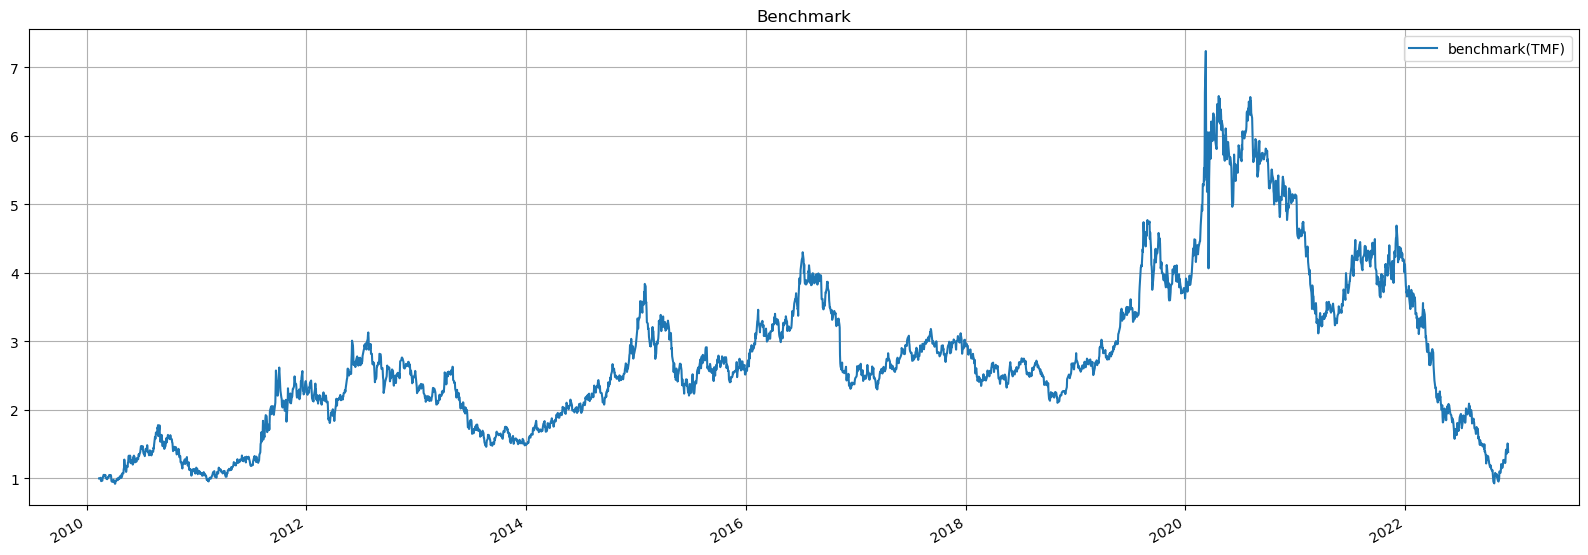

In [8]:
bm2_report.prices[start_day:].rebase(1).plot(figsize=(20,7), grid=True, title="Benchmark")
bm2_report.prices[start_day:].calc_stats().display()

In [9]:
bm_k = long_only_ew(assets_krw[tickers[0]].to_frame(), start_day, 'benchmark({}_krw)'.format(tickers[0]))
bm2_k = long_only_ew(assets_krw[tickers[1]].to_frame(), start_day, 'benchmark({}_krw)'.format(tickers[1]))

bm_k_report = bt.run(bm_k)
bm2_k_report = bt.run(bm2_k)

Stat                 benchmark(TQQQ_krw)
-------------------  ---------------------
Start                2010-02-11
End                  2022-12-09
Risk-free rate       0.00%

Total Return         5401.17%
Daily Sharpe         0.80
Daily Sortino        1.27
CAGR                 36.68%
Max Drawdown         -76.91%
Calmar Ratio         0.48

MTD                  -11.92%
3m                   -33.35%
6m                   -27.02%
YTD                  -72.20%
1Y                   -71.12%
3Y (ann.)            6.69%
5Y (ann.)            16.93%
10Y (ann.)           37.37%
Since Incep. (ann.)  36.68%

Daily Sharpe         0.80
Daily Sortino        1.27
Daily Mean (ann.)    49.30%
Daily Vol (ann.)     61.42%
Daily Skew           -0.30
Daily Kurt           6.49
Best Day             29.18%
Worst Day            -34.42%

Monthly Sharpe       0.86
Monthly Sortino      1.65
Monthly Mean (ann.)  43.93%
Monthly Vol (ann.)   50.87%
Monthly Skew         -0.14
Monthly Kurt         0.14
Best Month           

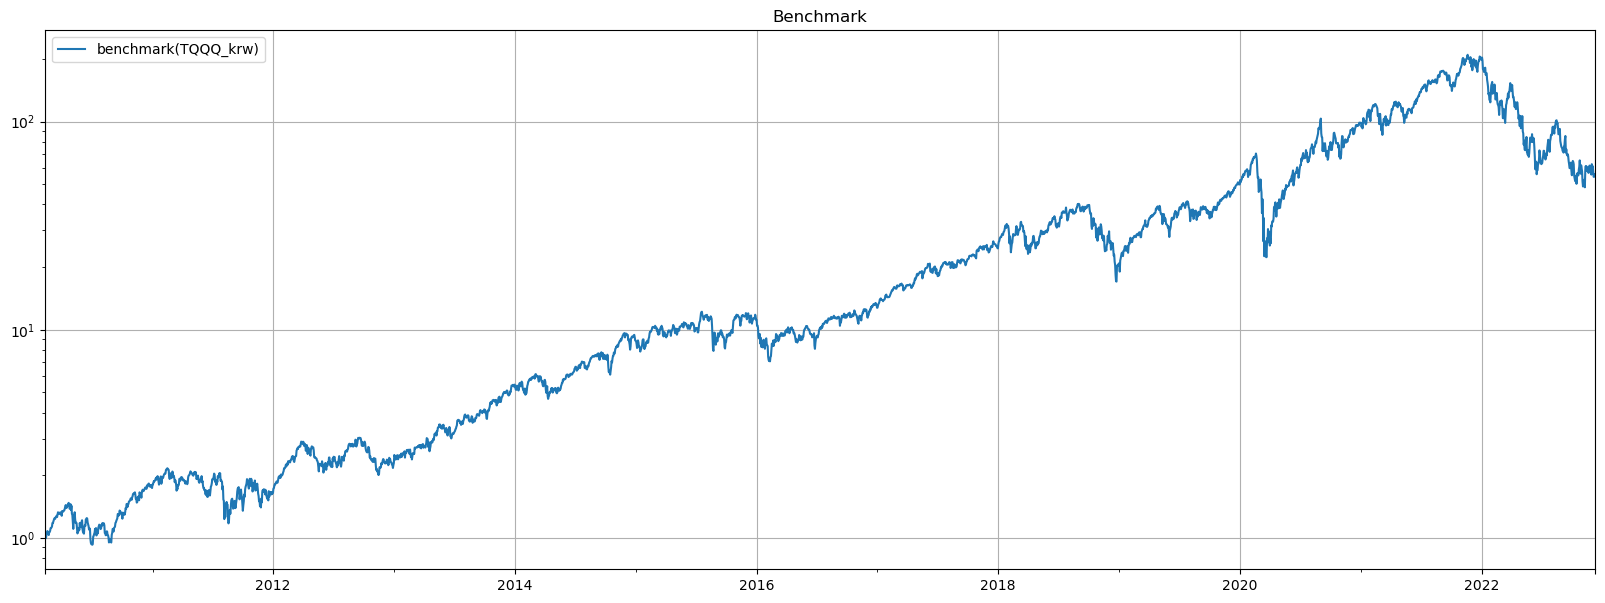

In [10]:
bm_k_report.prices[start_day:].rebase(1).plot(figsize=(20,7), grid=True, logy=True, title="Benchmark")
bm_k_report.prices[start_day:].calc_stats().display()

Stat                 benchmark(TMF_krw)
-------------------  --------------------
Start                2010-02-11
End                  2022-12-09
Risk-free rate       0.00%

Total Return         45.58%
Daily Sharpe         0.27
Daily Sortino        0.46
CAGR                 2.97%
Max Drawdown         -81.51%
Calmar Ratio         0.04

MTD                  8.58%
3m                   -11.46%
6m                   -18.67%
YTD                  -58.95%
1Y                   -59.37%
3Y (ann.)            -24.25%
5Y (ann.)            -9.76%
10Y (ann.)           -3.94%
Since Incep. (ann.)  2.97%

Daily Sharpe         0.27
Daily Sortino        0.46
Daily Mean (ann.)    11.12%
Daily Vol (ann.)     40.72%
Daily Skew           0.10
Daily Kurt           4.06
Best Day             19.38%
Worst Day            -16.85%

Monthly Sharpe       0.25
Monthly Sortino      0.54
Monthly Mean (ann.)  9.54%
Monthly Vol (ann.)   38.56%
Monthly Skew         0.96
Monthly Kurt         1.73
Best Month           46.90%
Wo

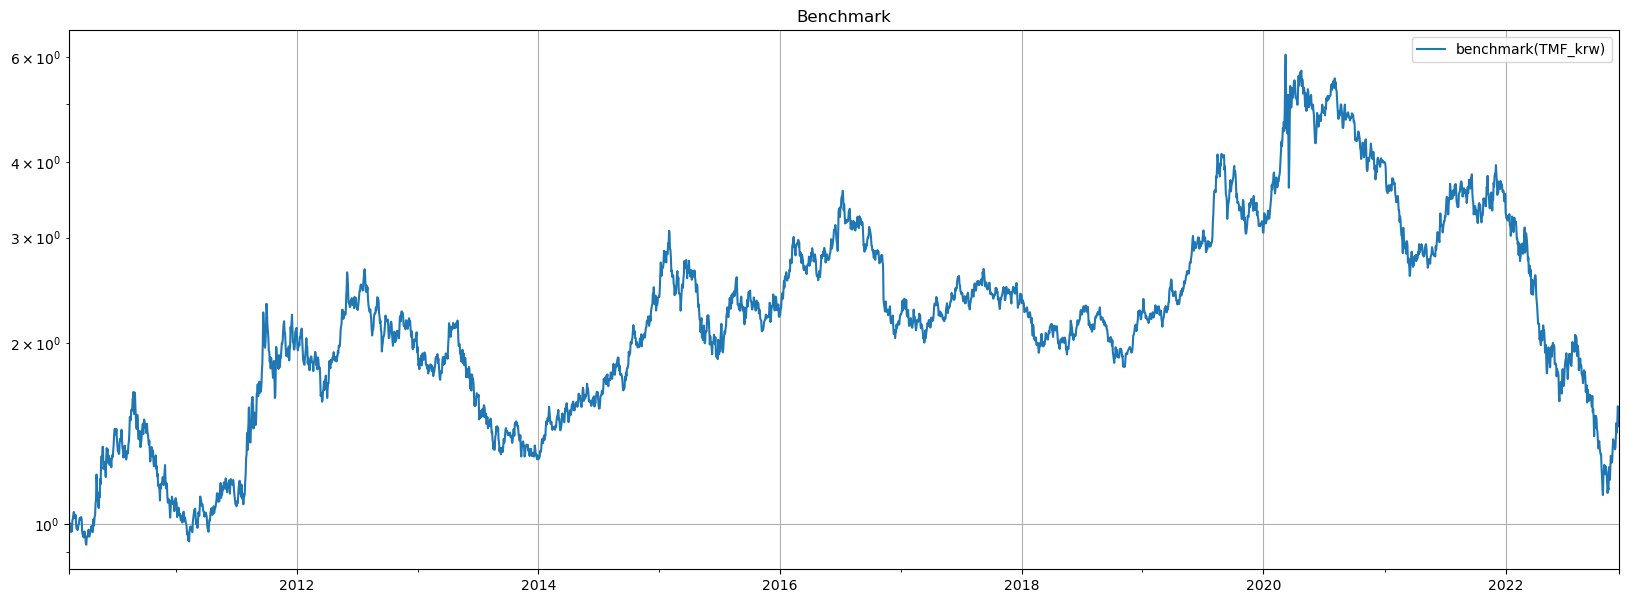

In [11]:
bm2_k_report.prices[start_day:].rebase(1).plot(figsize=(20,7), grid=True, logy=True, title="Benchmark")
bm2_k_report.prices[start_day:].calc_stats().display()

In [14]:
def FixedWeight_BT(assets, start_day, weights, run_on_end_of_period=False, returns=pd.DataFrame(), lag=1, ylookback=12, name='Fixed Weighted'):
    s = bt.Strategy(name, [bt.algos.RunAfterDate(start_day),
                           #bt.algos.RunMonthly(run_on_first_date=False, run_on_end_of_period=run_on_end_of_period, run_on_last_date=False),
                           bt.algos.RunQuarterly(run_on_first_date=False, run_on_end_of_period=run_on_end_of_period, run_on_last_date=False),
                           bt.algos.PrintDate(),
                           bt.algos.SelectAll(),
                           WeighFixed(returns, lag, ylookback, **weights),
                           #bt.algos.PrintTempData(),
                           #bt.algos.PrintInfo('{name}:{now}. Value:{_value:0.0f}, Price:{_price:0.4f}'),                           
                           bt.algos.Rebalance()])
    return bt.Backtest(s, assets, initial_capital=10000.0)

In [15]:
init=9
empty = pd.DataFrame()
fixedWeights = {}
for i in range(0,9):
    weights = {tickers[0]:init/10,tickers[1]:(10-init)/10}
    print(weights)
    fixedWeights[i] = FixedWeight_BT(assets[tickers], start_day, weights, False, empty, 0, 0, name='FW_{}:{}'.format(init,(10-init)))
    init = init - 1
fw_report = bt.run(*fixedWeights.values())

{'TQQQ': 0.9, 'TMF': 0.1}
{'TQQQ': 0.8, 'TMF': 0.2}
{'TQQQ': 0.7, 'TMF': 0.3}
{'TQQQ': 0.6, 'TMF': 0.4}
{'TQQQ': 0.5, 'TMF': 0.5}
{'TQQQ': 0.4, 'TMF': 0.6}
{'TQQQ': 0.3, 'TMF': 0.7}
{'TQQQ': 0.2, 'TMF': 0.8}
{'TQQQ': 0.1, 'TMF': 0.9}
2010-04-01 00:00:00


TypeError: '>=' not supported between instances of 'Timestamp' and 'float'

In [ ]:
fw_report.prices[start_day:].rebase(1).plot(figsize=(20,7), grid=True, logy=True, title="Fixed Weight")

In [ ]:
fw_report.prices[start_day:].calc_stats().display()

In [ ]:
fw_report.backtests['FW_4:6'].stats.drawdown_details.sort_values('drawdown').head(20)

In [ ]:
fw_report.backtests['FW_4:6'].stats.yearly_returns

In [ ]:
weights = {'TQQQ':0.3,'TMF':0.7}
ff = FixedWeight_BT(assets_krw[tickers], start_day, weights, False, empty, 0, 0, name='FWK')
ffr = bt.run(ff)

In [ ]:
init=9
fixedWeights_krw = {}
for i in range(0,9):
    weights = {tickers[0]:init/10,tickers[1]:(10-init)/10}
    print(weights)
    fixedWeights_krw[i] = FixedWeight_BT(assets_krw[tickers], start_day, weights, False, empty, 0, 0, name='FWK_{}:{}'.format(init,(10-init)))
    init = init - 1
fw_krw_report = bt.run(*fixedWeights_krw.values())

<AxesSubplot:title={'center':'Fixed Weight'}>

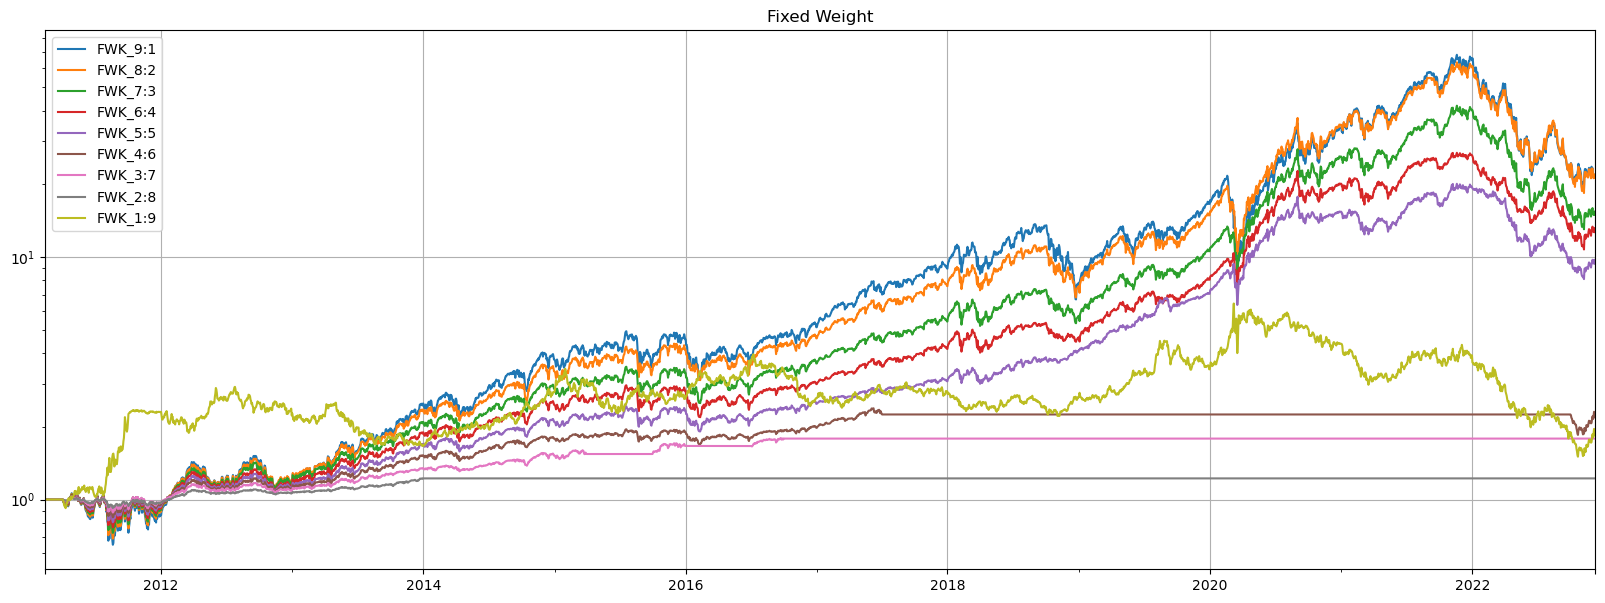

In [ ]:
fw_krw_report.prices[start_day:].rebase(1).plot(figsize=(20,7), grid=True, logy=True, title="Fixed Weight")

In [21]:
fw_krw_report.prices[start_day:].calc_stats().display()

Stat                 FWK_9:1     FWK_8:2     FWK_7:3     FWK_6:4     FWK_5:5     FWK_4:6     FWK_3:7     FWK_2:8     FWK_1:9
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2011-02-11  2011-02-11  2011-02-11  2011-02-11  2011-02-11  2011-02-11  2011-02-11  2011-02-11  2011-02-11
End                  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         2044.01%    2028.99%    1395.52%    1166.71%    838.62%     118.47%     78.33%      22.20%      83.95%
Daily Sharpe         0.75        0.79        0.78        0.83        0.83        0.56        0.61        0.42        0.32
Daily Sortino        1.18        1.25        1.23        1.32        1.30        0.86        0.92        0.61        0.53

C:\Users\KOSCOM\anaconda3\lib\site-packages\ffn\core.py:2299: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)
C:\Users\KOSCOM\anaconda3\lib\site-packages\ffn\core.py:2299: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)


In [22]:
fw_krw_report.backtests['FWK_4:6'].stats.drawdown_details.sort_values('drawdown').head(20)

,Start,End,Length,drawdown
176,2020-09-03 00:00:00,2022-12-09 00:00:00,827,-0.555846
159,2020-03-10 00:00:00,2020-04-08 00:00:00,29,-0.263561
18,2011-02-17 00:00:00,2012-02-03 00:00:00,351,-0.194426
122,2018-03-13 00:00:00,2018-06-14 00:00:00,93,-0.160813
3,2010-04-26 00:00:00,2010-10-15 00:00:00,172,-0.156136
77,2015-07-22 00:00:00,2016-08-23 00:00:00,398,-0.155735
30,2012-09-20 00:00:00,2013-05-02 00:00:00,224,-0.138013
153,2019-09-05 00:00:00,2020-01-24 00:00:00,141,-0.124263
125,2018-07-16 00:00:00,2019-01-04 00:00:00,172,-0.122286
27,2012-03-28 00:00:00,2012-09-06 00:00:00,162,-0.115423


In [23]:
assets_cash = assets[tickers].copy()
assets_cash['SAFE'] = assets[safe_ticker[0]].copy()
print(assets_cash)

                 TQQQ        TMF       SAFE
Date                                       
2010-02-11   0.431471   6.695425  86.560020
2010-02-12   0.433238   6.771188  86.560020
2010-02-16   0.450019   6.831800  86.560020
2010-02-17   0.457656   6.613164  86.503403
2010-02-18   0.466332   6.500601  86.541138
...               ...        ...        ...
2022-12-05  22.230000   9.230000  91.449997
2022-12-06  20.820000   9.590000  91.480003
2022-12-07  20.570000  10.230000  91.480003
2022-12-08  21.299999  10.160000  91.540001
2022-12-09  20.889999   9.380000  91.529999

[3231 rows x 3 columns]


In [24]:
# 수익률곡선 + 고정비중 투자전력
init=9
yfixedWeights = {}
for i in range(0,9):
    weights = {tickers[0]:init/10,tickers[1]:(10-init)/10,'SAFE':0}
    print(weights)
    returns = fw_report.prices['FW_{}:{}'.format(init,(10-init))].rebase(1).to_frame().copy()
    print('returns[FW_{}:{}]\n'.format(init, (10-init)), returns)
    yfixedWeights[i] = FixedWeight_BT(assets_cash, start_day, weights, False, returns, 1, 12, name='yFW_{}:{}'.format(init,(10-init)))
    init = init - 1
yfw_report = bt.run(*yfixedWeights.values())

{'TQQQ': 0.9, 'TMF': 0.1, 'SAFE': 0}
returns[FW_9:1]
                FW_9:1
2010-02-10   1.000000
2010-02-11   1.000000
2010-02-12   1.000000
2010-02-16   1.000000
2010-02-17   1.000000
...               ...
2022-12-05  45.806823
2022-12-06  43.351708
2022-12-07  43.190775
2022-12-08  44.517285
2022-12-09  43.382101

[3232 rows x 1 columns]
{'TQQQ': 0.8, 'TMF': 0.2, 'SAFE': 0}
returns[FW_8:2]
                FW_8:2
2010-02-10   1.000000
2010-02-11   1.000000
2010-02-12   1.000000
2010-02-16   1.000000
2010-02-17   1.000000
...               ...
2022-12-05  46.724799
2022-12-06  44.683882
2022-12-07  44.884243
2022-12-08  46.054454
2022-12-09  44.597725

[3232 rows x 1 columns]
{'TQQQ': 0.7, 'TMF': 0.3, 'SAFE': 0}
returns[FW_7:3]
                FW_7:3
2010-02-10   1.000000
2010-02-11   1.000000
2010-02-12   1.000000
2010-02-16   1.000000
2010-02-17   1.000000
...               ...
2022-12-05  42.185481
2022-12-06  40.764994
2022-12-07  41.278057
2022-12-08  42.167997
2022-12-09  40.580

Stat                 yFW_9:1     yFW_8:2     yFW_7:3     yFW_6:4     yFW_5:5     yFW_4:6     yFW_3:7     yFW_2:8     yFW_1:9
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2010-02-11  2010-02-11  2010-02-11  2010-02-11  2010-02-11  2010-02-11  2010-02-11  2010-02-11  2010-02-11
End                  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         1216.22%    2106.03%    2714.26%    2855.40%    2281.60%    1633.55%    916.93%     420.72%     186.69%
Daily Sharpe         0.70        0.85        0.98        1.08        1.09        1.02        0.87        0.64        0.44
Daily Sortino        1.05        1.30        1.52        1.68        1.68        1.58        1.37        1.01        0.6

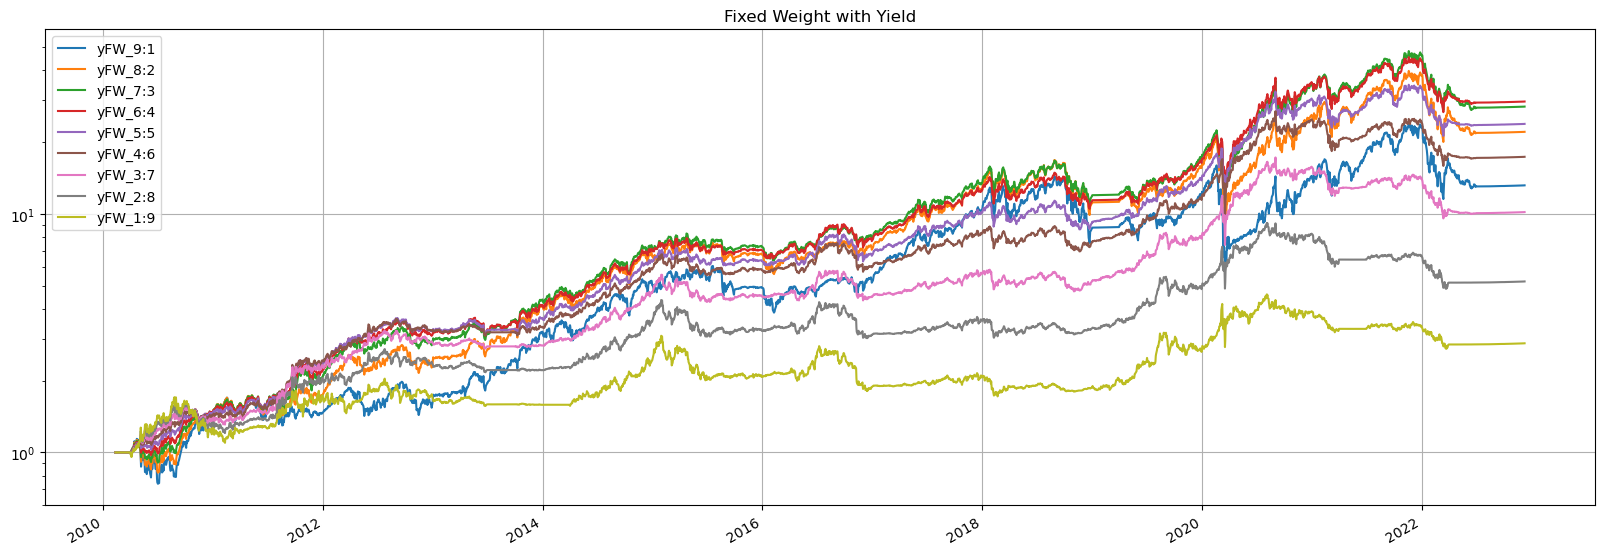

In [25]:
yfw_report.prices[start_day:].rebase(1).plot(figsize=(20,7), grid=True, logy=True, title="Fixed Weight with Yield")
yfw_report.prices[start_day:].calc_stats().display()

In [26]:
rolling = 126
rolling_corr = assets.rolling(rolling).corr()['TQQQ'].loc[:,'TMF'].to_frame()
print('rolling corr \n', rolling_corr)
start_day = rolling_corr['TQQQ'].first_valid_index()
print('start_day : ', start_day)

rolling corr 
                 TQQQ
Date                
2010-02-11       NaN
2010-02-12       NaN
2010-02-16       NaN
2010-02-17       NaN
2010-02-18       NaN
...              ...
2022-12-05  0.806093
2022-12-06  0.803474
2022-12-07  0.799382
2022-12-08  0.796501
2022-12-09  0.797376

[3231 rows x 1 columns]
start_day :  2010-08-11 00:00:00


In [33]:
print(start_day - pd.DateOffset(days=rolling))

2010-04-07 00:00:00


In [27]:
def FixedWeightWithCorr_BT(assets, start_day, weights, run_on_end_of_period=False, rolling=126, corr_df=pd.DataFrame(), corr=0.5, lag=1, name='Fixed Weighted'):
    s = bt.Strategy(name, [bt.algos.RunAfterDate(start_day),
                           #bt.algos.RunMonthly(run_on_first_date=False, run_on_end_of_period=run_on_end_of_period, run_on_last_date=False),
                           bt.algos.RunQuarterly(run_on_first_date=False, run_on_end_of_period=run_on_end_of_period, run_on_last_date=False),
                           bt.algos.PrintDate(),
                           bt.algos.SelectAll(),
                           WeighFixedWithCorr(lag, rolling, corr_df, corr, **weights),
                           bt.algos.PrintTempData(),
                           #bt.algos.PrintInfo('{name}:{now}. Value:{_value:0.0f}, Price:{_price:0.4f}'),                           
                           bt.algos.Rebalance()])
    return bt.Backtest(s, assets, initial_capital=10000.0)

In [30]:
tmp = rolling_corr.loc['2010-09-30'].values
print(tmp)
if (tmp < 1) :
    print("True")

[-0.68501643]
True


In [31]:
# 상관계수 + 고정비중 투자전력
init=9
cfixedWeights = {}
for i in range(0,1):
    weights = {tickers[0]:init/10,tickers[1]:(10-init)/10,'SAFE':0}
    print(weights)
    cfixedWeights[i] = FixedWeightWithCorr_BT(assets_cash, start_day, weights, False, rolling, rolling_corr, 0.5, 1, name='cFW_{}:{}'.format(init,(10-init)))
    init = init - 1
cfw_report = bt.run(*cfixedWeights.values())

{'TQQQ': 0.9, 'TMF': 0.1, 'SAFE': 0}
2010-10-01 00:00:00
t0 = 2010-09-30 00:00:00, corr_df.log[2010-09-30 00:00:00] = TQQQ   -0.685016
Name: 2010-09-30 00:00:00, dtype: float64 


OutOfBoundsDatetime: Out of bounds nanosecond timestamp: 1677-09-21 00:00:00

Stat                 cFW_9:1     cFW_8:2     cFW_7:3     cFW_6:4     cFW_5:5     cFW_4:6     cFW_3:7     cFW_2:8     cFW_1:9
-------------------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
Start                2010-02-11  2010-02-11  2010-02-11  2010-02-11  2010-02-11  2010-02-11  2010-02-11  2010-02-11  2010-02-11
End                  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09  2022-12-09
Risk-free rate       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%       0.00%

Total Return         8842.69%    9114.83%    8330.96%    6858.80%    5134.57%    3506.67%    2180.85%    1222.85%    600.90%
Daily Sharpe         0.97        1.07        1.15        1.22        1.22        1.14        0.99        0.79        0.60
Daily Sortino        1.52        1.68        1.82        1.93        1.94        1.82        1.58        1.29        0.9

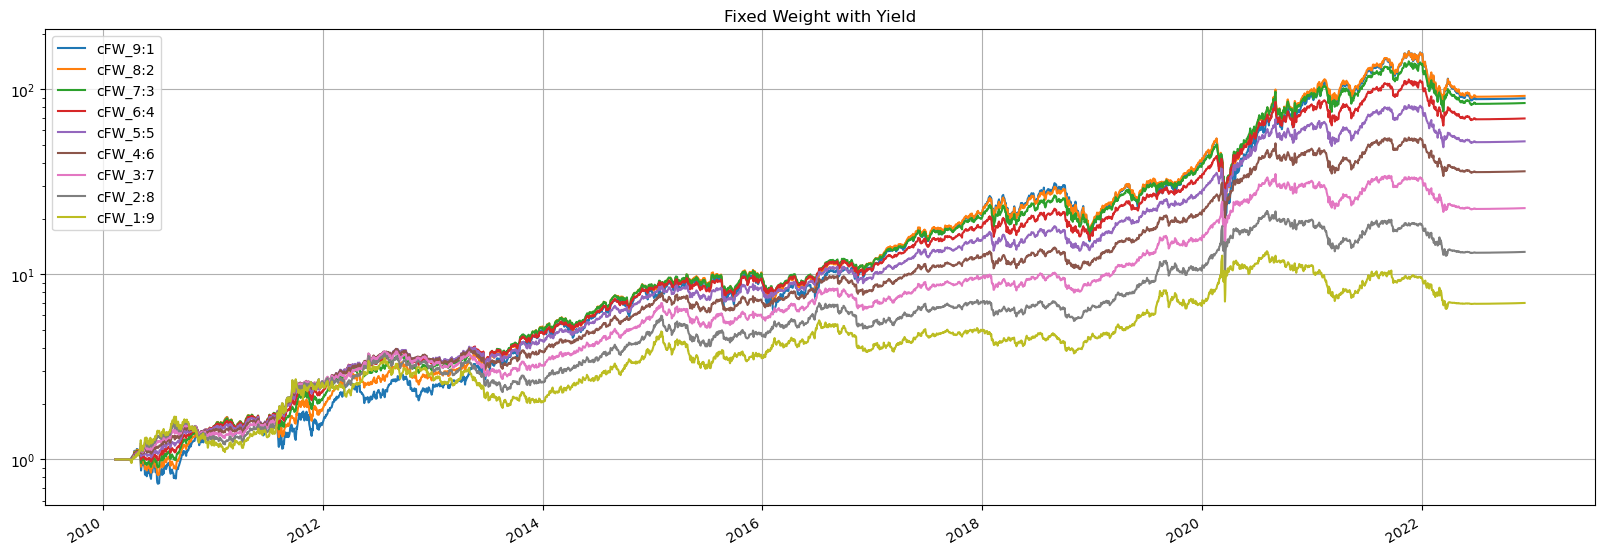

In [28]:
cfw_report.prices[start_day:].rebase(1).plot(figsize=(20,7), grid=True, logy=True, title="Fixed Weight with Yield")
cfw_report.prices[start_day:].calc_stats().display()

In [29]:
cfw_report.get_transactions('cFW_5:5')

price  quantity
Date       Security                     
2010-04-01 TMF        6.577304     760.0
           TQQQ       0.576784    8668.0
2010-07-01 TMF        9.975431    -215.0
           TQQQ       0.379986    5644.0
2010-10-01 TMF       10.747917     104.0
...                        ...       ...
2022-04-01 SAFE      90.492523    5275.0
           TMF       19.563517  -15455.0
           TQQQ      57.930000   -3020.0
2022-07-01 SAFE      90.575684     443.0
           TQQQ      24.389999   -1648.0

[111 rows x 2 columns]

<AxesSubplot:>

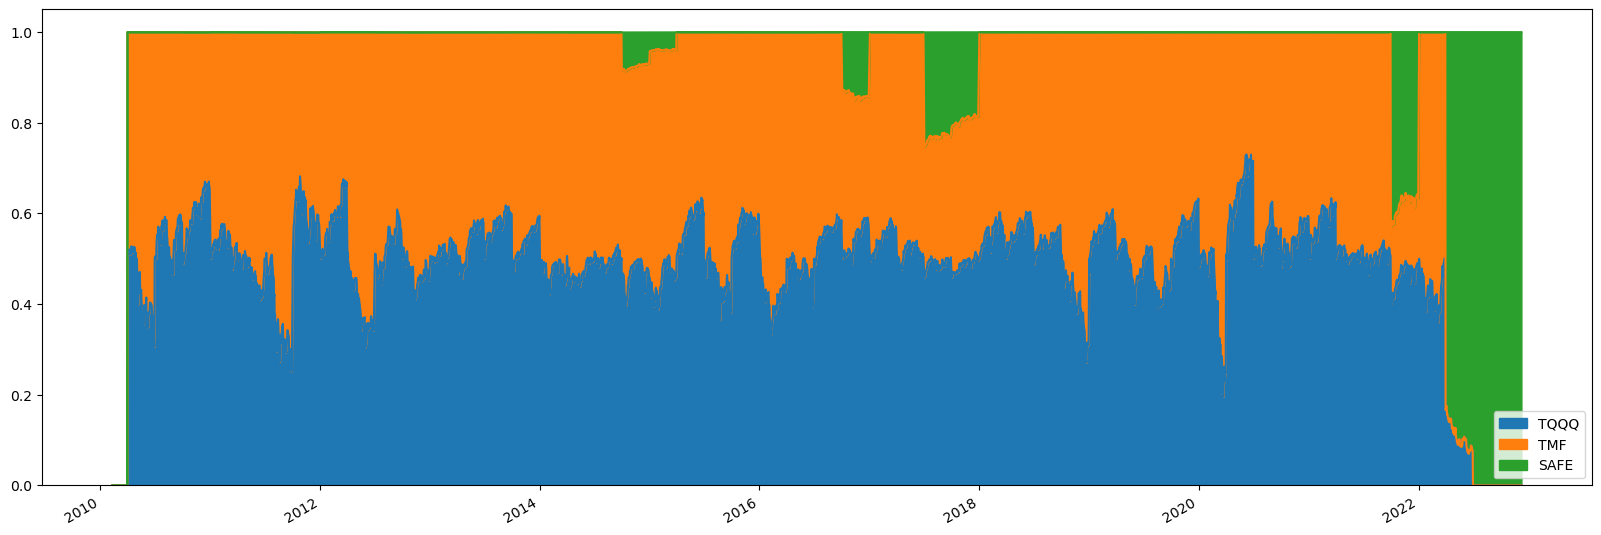

In [35]:
cfw_report.get_security_weights('cFW_5:5').plot.area(figsize=(20,7))

In [1]:
cfw_report.prices['cFW_5:5'].to_drawdown_series().plot.area(figsize=(20,7))

NameError: name 'cfw_report' is not defined